In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec
import glob
import netCDF4 as ncdf
from pynhhd import nHHD

import time

from datetime import datetime

# Local import 

from spectra.py_spectra import *


In [3]:
#-----------------------------------------------------------------
#
# This code can run and plot power spectra from a single day
#

def run_spectral_analysis(in_dir, out_dir, day, suffix_name = ["HRRR_ECONUS", "RRFS_ECONUS"], analysis_levels = [4, 18, 32]):
    

    hrrr_nhhd_file = str(os.path.join(in_dir, "%s_%s_hhd.nc" % (day, suffix_name[0])))
    rrfs_nhhd_file = str(os.path.join(in_dir, "%s_%s_hhd.nc" % (day, suffix_name[1])))
    
    hrrr_full_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[0])))
    rrfs_full_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[1])))
    
    print(hrrr_nhhd_file, hrrr_full_file)
    print(rrfs_nhhd_file, rrfs_full_file)
    
    # Open data sets

    hrrr_nhhd = xr.open_dataset(hrrr_nhhd_file) 
    rrfs_nhhd = xr.open_dataset(rrfs_nhhd_file)
    
    zlevels = hrrr_nhhd.z
    
    hrrr_full = xr.open_dataset(hrrr_full_file) 
    rrfs_full = xr.open_dataset(rrfs_full_file)

    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these three levels are averaged together

        klevels = [k-1, k, k+1]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

        hrrr_u  = np.nan_to_num(hrrr_full.u_interp.isel(fhour=1,nz=klevels).values).astype('float64')
        hrrr_v  = np.nan_to_num(hrrr_full.v_interp.isel(fhour=1,nz=klevels).values).astype('float64')

        hrrr_ur = np.nan_to_num(hrrr_nhhd.ur.isel(fhour=1,nz=klevels).values).astype('float64')
        hrrr_vr = np.nan_to_num(hrrr_nhhd.vr.isel(fhour=1,nz=klevels).values).astype('float64')
        
        hrrr_ud = np.nan_to_num(hrrr_nhhd.ud.isel(fhour=1,nz=klevels).values).astype('float64')
        hrrr_vd = np.nan_to_num(hrrr_nhhd.vd.isel(fhour=1,nz=klevels).values).astype('float64')

        hrrr_ke  = 0.5*(hrrr_u**2  + hrrr_v**2)
        hrrr_rke = 0.5*(hrrr_ur**2 + hrrr_vr**2)
        hrrr_dke = 0.5*(hrrr_ud**2 + hrrr_vd**2)
        
        rrfs_u  = np.nan_to_num(rrfs_full.u_interp.isel(fhour=1,nz=klevels).values).astype('float64')
        rrfs_v  = np.nan_to_num(rrfs_full.v_interp.isel(fhour=1,nz=klevels).values).astype('float64')

        rrfs_ur = np.nan_to_num(rrfs_nhhd.ur.isel(fhour=1,nz=klevels).values).astype('float64')
        rrfs_vr = np.nan_to_num(rrfs_nhhd.vr.isel(fhour=1,nz=klevels).values).astype('float64')

        rrfs_ud = np.nan_to_num(rrfs_nhhd.ud.isel(fhour=1,nz=klevels).values).astype('float64')
        rrfs_vd = np.nan_to_num(rrfs_nhhd.vd.isel(fhour=1,nz=klevels).values).astype('float64')
         
        rrfs_ke  = 0.5*(rrfs_u**2  + rrfs_v**2)
        rrfs_rke = 0.5*(rrfs_ur**2 + rrfs_vr**2)
        rrfs_dke = 0.5*(rrfs_ud**2 + rrfs_vd**2)

        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        if k < 8:
            ylim = [1.0e10,1.0e20]
        else:
            ylim = [1.0e12,1.0e22]
            
        axis    = 0
        func    = get_spectra2D_RAD
        detrend = True

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        plot_spectra(rrfs_rke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='r', linewidth=2.0, ylim=ylim)      
        plot_spectra(rrfs_dke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='r', linestyle='--',ylim=ylim) 
        plot_spectra(hrrr_rke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='k', linewidth=2.0, ylim=ylim) 
        plot_spectra(hrrr_dke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='HRRR:black\n\nRRFS:red',
                    ptitle='Rotational and Divergent KE', linecolor='k', linestyle='--', LinsborgSlope=True, ylim=ylim)
        
        ax1 = fig.add_subplot(gs[0, 1])
        if k < 8:
            ylim = [1.0e12,1.0e22]
        else:
            ylim = [1.0e14,1.0e24]
        
        plot_spectra(rrfs_ke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='',                       linecolor='r', ylim=ylim)      
        plot_spectra(hrrr_ke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='HRRR:black\n\nRRFS:red', linecolor='k', 
                    ptitle='Total KE', LinsborgSlope=True, ylim=ylim)

        plt.suptitle("Total KE Avg Case Day %s \n Height Level: %3.1f km" % (day, zlevels[k]/1000.), fontsize=20)

        plt.savefig("%s/%s_Rotational and Divergent_KE_Spectra_%3.1fkm.png" % (out_dir, day, zlevels[k]/1000.),bbox_inches='tight', dpi=300)


Running day:  2022053000

/work/wicker/ECONUS/2022053000_HRRR_ECONUS_hhd.nc /work/wicker/ECONUS/2022053000_HRRR_ECONUS.nc
/work/wicker/ECONUS/2022053000_RRFS_ECONUS_hhd.nc /work/wicker/ECONUS/2022053000_RRFS_ECONUS.nc
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
plot_spectra: DETREND = True

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
plot_spectra: DETREND = True

                    ---------------------------------------------------------------------------------

FileNotFoundError: [Errno 2] No such file or directory: '/work/wicker/CAM_analysis_tools/2022__new_spectra/2022053000_Rotational and Divergent_KE_Spectra_2.0km.png'

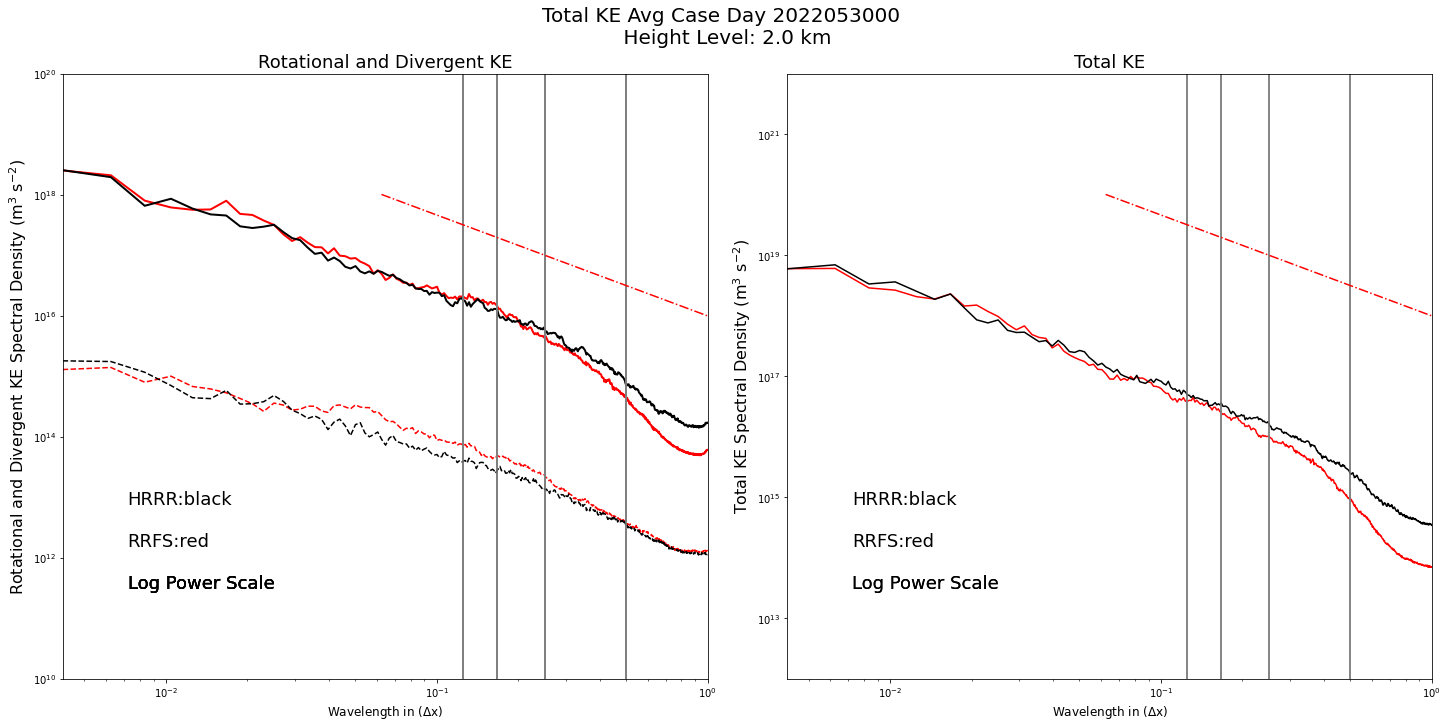

In [4]:
in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022__new_spectra"
case_days = ["2022053000"]

            # ["2022050400"]
            # # ,"2022051200",
            # # "2022051400",
            # # "2022051500",
            # # "2022051900",
            # # "2022052300",
            # # "2022052400",
            # # "2022052700",
            # # "2022053000",
            # # "2022060700"]

#case_days = ["2022060700"]

for d in case_days:
    print("Running day:  %s\n" % d)
    ret = run_spectral_analysis(in_dir, out_dir, d, analysis_levels = [4, 16, 28, 38])
    


====> Begin processing runs


----> Processing run: HRRR for day:  2022050400 

          /work/wicker/ECONUS/2022050400_HRRR_ECONUS_hhd.nc

          /work/wicker/ECONUS/2022050400_HRRR_ECONUS.nc

          F-HOUR:  0  K-LEVEL:  4
                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


          F-HOUR:  1  K-LEVEL:  4
                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


         

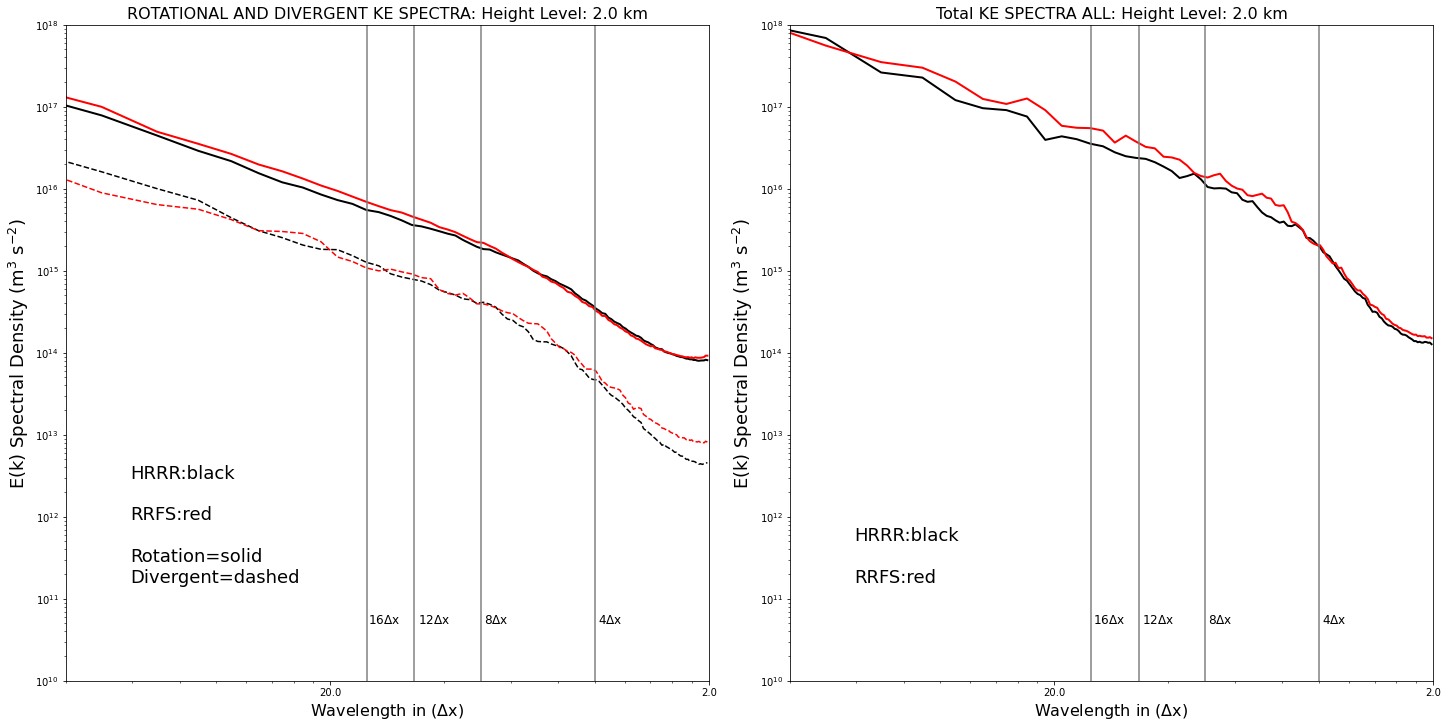

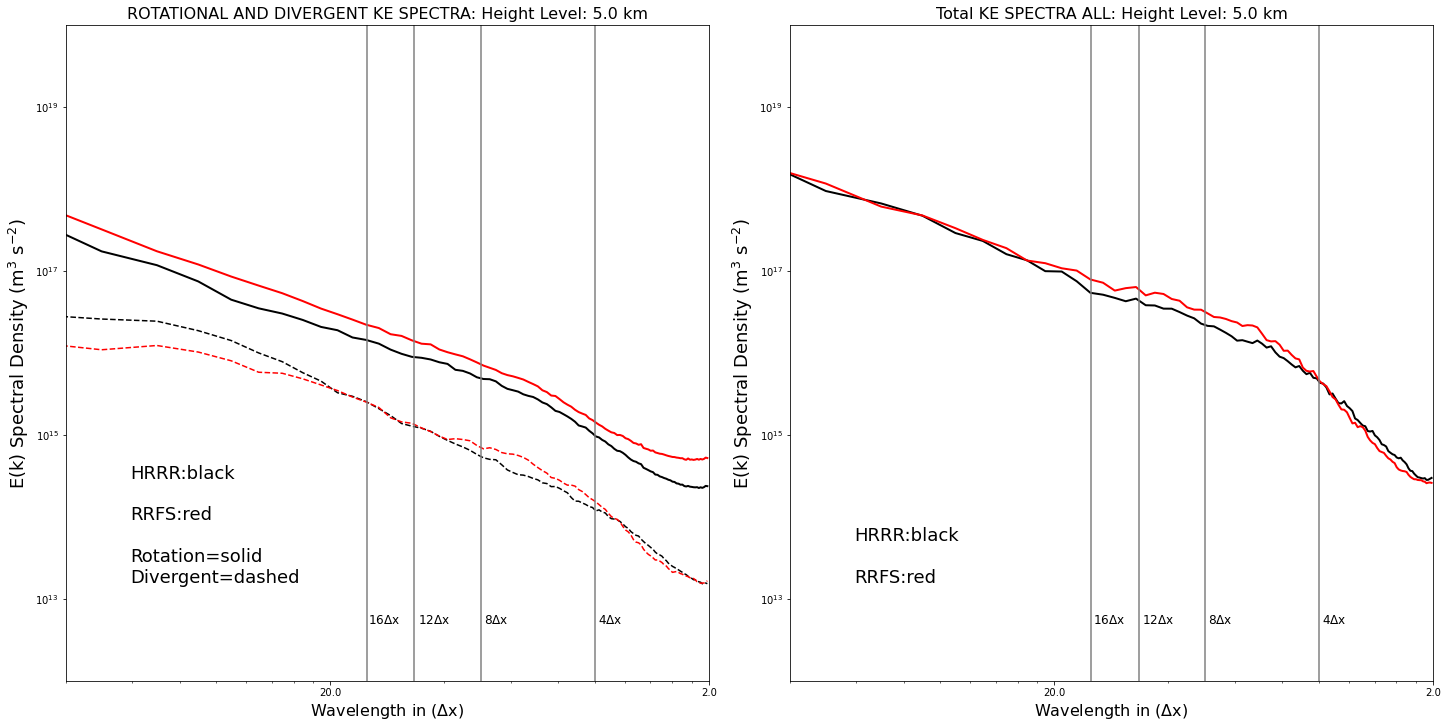

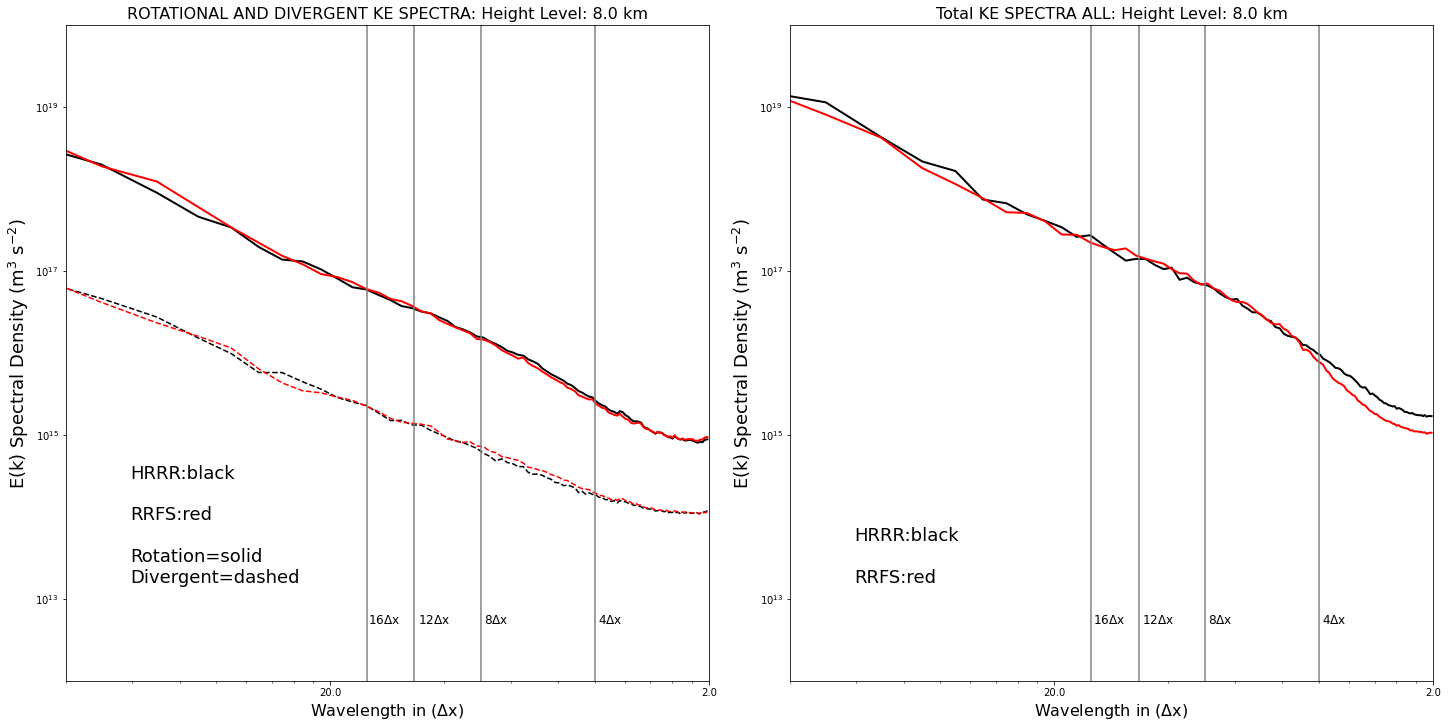

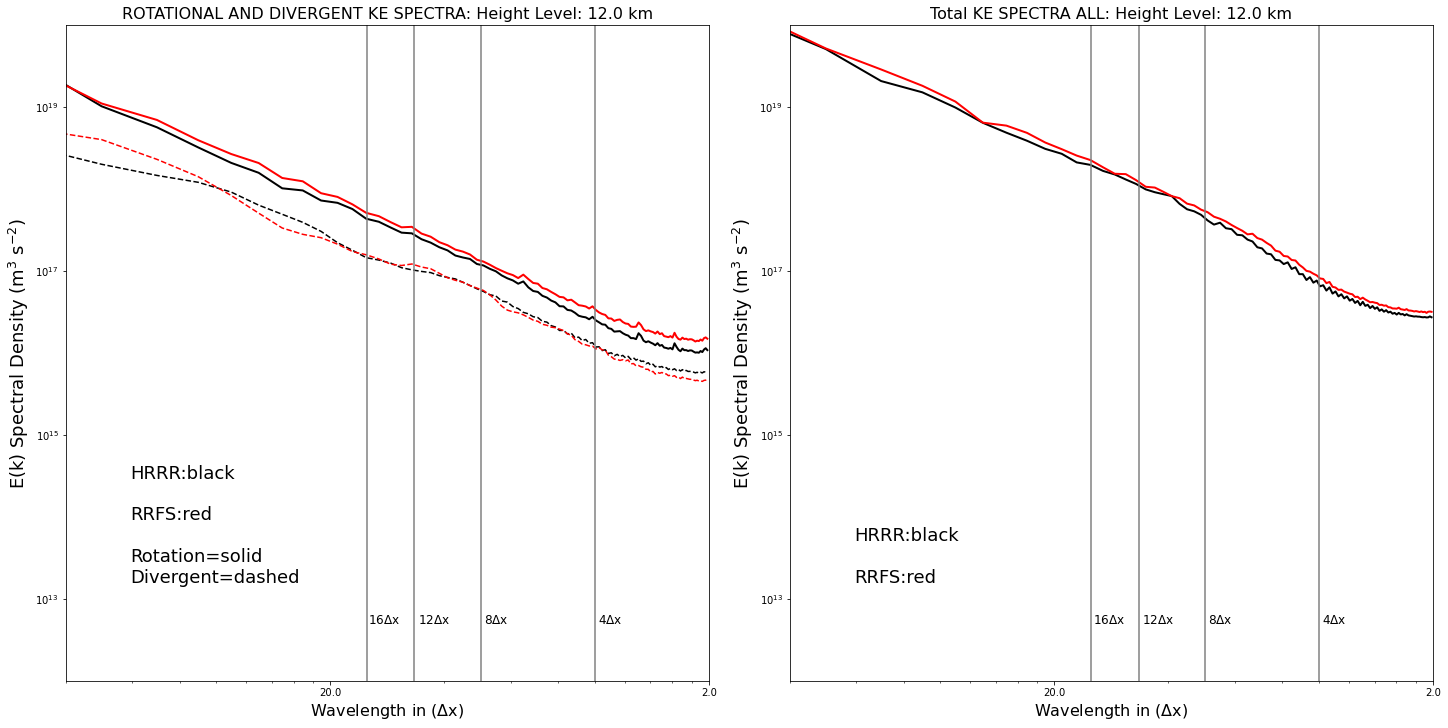

In [6]:
import matplotlib.ticker as mticker

analysis_levels = [4, 16, 28, 38]

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"

case_days = ["2022050400",
             "2022051200"]

             # "2022051400",
             # "2022051500",
             # "2022051900",
             # "2022052300",
             # "2022052400",
             # "2022052700",
             # "2022053000",
             # "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_rke =  {"HRRR":[], 
            "RRFS":[]}

ret_dke =  {"HRRR":[], 
            "RRFS":[]}

ret_tke =  {"HRRR":[], 
            "RRFS":[]}

avg_rke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}
avg_dke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}
avg_tke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}



func   = get_spectra2D_RAD
dtrend = True
axis   = None

delta  = False

suffix_names = ["HRRR","RRFS"]
region       = "ECONUS"
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
                
    # these levels are averaged together

    klevels = [k-1, k, k+1]

    for n, day in enumerate(case_days):
        
        for run in suffix_names:

            print("\n----> Processing run: %s for day:  %s \n" % (run, day))
            
            file1  = str(os.path.join(in_dir, "%s_%s_%s_hhd.nc" % (day, run, region)))
            print("          %s\n" % file1)
            
            file2  = str(os.path.join(in_dir, "%s_%s_%s.nc" % (day, run, region)))
            print("          %s\n" % file2)
            
            # Open data set

            ds = xr.open_dataset(file1)
            do = xr.open_dataset(file2)
            
            zlevels = ds.z
            
            nhours = ds.dims['fhour']
            
            store_rke = []
            store_dke = []
            store_tke = []
            
            for t in np.arange(nhours):
                
                print("          F-HOUR:  %d  K-LEVEL:  %d" % (t, k))
            
                # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

                u  = np.nan_to_num(do.u_interp.isel(fhour=t,nz=klevels).values).astype('float64')
                v  = np.nan_to_num(do.v_interp.isel(fhour=t,nz=klevels).values).astype('float64')

                ur = np.nan_to_num(ds.ur.isel(fhour=t,nz=klevels).values).astype('float64')
                vr = np.nan_to_num(ds.vr.isel(fhour=t,nz=klevels).values).astype('float64')

                ud = np.nan_to_num(ds.ud.isel(fhour=t,nz=klevels).values).astype('float64')
                vd = np.nan_to_num(ds.vd.isel(fhour=t,nz=klevels).values).astype('float64')

                tke = 0.5*(u**2  + v**2)
                rke = 0.5*(ur**2 + vr**2)
                dke = 0.5*(ud**2 + vd**2)

                # Compute rke spectra...

                ret = get_spectraND(rke, func = func, dtrend = dtrend)

                store_rke.append(np.interp(avg_grid, ret[2], ret[1]))

                # Compute dke spectra...

                ret = get_spectraND(dke, func = func, dtrend = dtrend)

                store_dke.append(np.interp(avg_grid, ret[2], ret[1]))

                # Compute hke spectra...

                ret = get_spectraND(tke, func = func, dtrend = dtrend)

                store_tke.append(np.interp(avg_grid, ret[2], ret[1]))
            
            # Average spectra over all the fhours
            
            avg_rke[run][n][:] = np.asarray(store_rke).mean(axis=0)
            avg_dke[run][n][:] = np.asarray(store_dke).mean(axis=0)
            avg_tke[run][n][:] = np.asarray(store_tke).mean(axis=0)

            ds.close()
            do.close()
            
    # Now average spectra over all the days...
    
    rke_hrrr = avg_rke['HRRR'].mean(axis=0)
    rke_rrfs = avg_rke['RRFS'].mean(axis=0)
    
    dke_hrrr = avg_dke['HRRR'].mean(axis=0)
    dke_rrfs = avg_dke['RRFS'].mean(axis=0)
           
    tke_hrrr = avg_tke['HRRR'].mean(axis=0)
    tke_rrfs = avg_tke['RRFS'].mean(axis=0)
   
    # Now plot the average spectra

    fig = plt.figure(constrained_layout=True,figsize=(20,10))

    gs = gridspec.GridSpec(1, 2, figure=fig)

    axes = fig.add_subplot(gs[0, 0])

    legend='HRRR:black\n\nRRFS:red\n\nRotation=solid\nDivergent=dashed'


    axes.loglog(avg_grid, rke_hrrr, color='black', linewidth=2.)
    axes.loglog(avg_grid, rke_rrfs, color='red',   linewidth=2.)
    
    axes.loglog(avg_grid, dke_hrrr, color='black', linestyle='--')
    axes.loglog(avg_grid, dke_rrfs, color='red',   linestyle='--')

    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.15), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    if k < 8:
            ylim = [1.0e10,1.0e18]
    else:
        ylim = [1.0e12,1.0e20]
        
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.01, 0.005, 0.0035, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"E(k) Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)
    plt.title("ROTATIONAL AND DIVERGENT KE SPECTRA: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)
    
    # KE spectra
    
    axes = fig.add_subplot(gs[0, 1])

    legend='HRRR:black\n\nRRFS:red'

    
    axes.loglog(avg_grid, tke_hrrr, color='black', linewidth=2.)
    axes.loglog(avg_grid, tke_rrfs, color='red',   linewidth=2.)
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.15), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    if k < 8:
        ylim = [1.0e10,1.0e18]
    else:
        ylim = [1.0e12,1.0e20]
        
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.01, 0.005, 0.0035, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"E(k) Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    plt.title("Total KE SPECTRA ALL: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'KE_SPECTRA_2PANEL', zlevels[k]/1000.),bbox_inches='tight',dpi=300)



In [ ]:
import matplotlib.ticker as mticker

analysis_levels  = [34]

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/"
case_days = ["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"HRRR":[], 
             "RRFS":[]}

avg_data = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
            "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_RAD
dtrend = False
axis = None

delta = False

suffix_names = ["HRRR","RRFS"]
region = "ECONUS"
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
    for n, day in enumerate(case_days):
        for run in suffix_names:

            print("\n----> Processing run: %s for day:  %s \n" % (run, day))
            
            myfile  = str(os.path.join(in_dir, "%s_%s_%s.nc" % (day, run, region)))
            print("          %s\n" % myfile)

            # Open data set

            data = xr.open_dataset(myfile)
            
            zlevels = data.z
            
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-1, k, k+1]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_u = np.nan_to_num(data.u_interp.isel(nz=klevels).values).astype('float64')
            data_v = np.nan_to_num(data.v_interp.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = get_spectraND(data_u, varray=data_v, func = func, detrend=dtrend)

            ret_data[run].append(ret)
            print(len(ret_data[run]))

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])
            
            data.close()

# Now post the runs....

    legend='HRRR:black\nRRFS:red'

    avg_hrrr = avg_data['HRRR'].mean(axis=0)
    avg_rrfs = avg_data['RRFS'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_rrfs = avg_rrfs[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_rrfs,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_rrfs, color='red')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [1.0e1,1.0e6]

    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.0075, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)
        
    xpt = [2.0/16.,2.0/2.0]
    dlnx = np.log(xpt[1]) - np.log(xpt[0])
    y1   = ylim[1]/(100.)
    y0   = np.exp(np.log(y1) + 5./3. * dlnx)
    ypt  = [y0,y1]
    axes.loglog(xpt, ypt, color='red',linestyle='-.',label='k$^{-5/3}$')

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"KE Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    plt.suptitle("KE_SPECTRA_ALL: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/KE_SPECTRA_ALL_%3.1fkm.png" % (out_dir, zlevels[k]/1000.),bbox_inches='tight',dpi=300)
    
    


====> Begin processing runs


----> Processing run: HRRR for day:  2022050400 

          /work/wicker/ECONUS/2022050400_HRRR_ECONUS.nc

          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 18

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


1

----> Processing run: RRFS for day:  2022050400 

          /work/wicker/ECONUS/2022050400_RRFS_ECONUS.nc

          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 18

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now b